# packages

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

# settings

In [9]:
# default column number pandas
pd.options.display.max_columns = 200

# plot style
sns.set(palette = "colorblind", font_scale = 1.5)

# data
downloaded from [https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index.aspx](https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index.aspx)

In [10]:
hpi = pd.read_excel("/Users/nicholasmichalak/sandbox/hpi-analysis/data/HPI_AT_BDL_cbsa.xlsx", skiprows = 6)

# better column names
## function
def adjust_colname(x: str, to_replace: dict):
    for s, r in to_replace.items():
        # replace
        x = x.replace(s, r)
    return x.lower()

# replace names
hpi.columns = [adjust_colname(col, {" ": "_", "%": "pct", "(": "", ")": ""}) for col in hpi.columns]

# see it
hpi

,cbsa,name,year,annual_change_pct,hpi,hpi_with_1990_base,hpi_with_2000_base
0,1,Alabama(non CBSA areas),1985,.,100.00,91.76,63.20
1,1,Alabama(non CBSA areas),1986,5.89,105.89,97.16,66.92
2,1,Alabama(non CBSA areas),1987,0.78,106.71,97.92,67.44
3,1,Alabama(non CBSA areas),1988,-0.49,106.19,97.44,67.11
4,1,Alabama(non CBSA areas),1989,5.04,111.55,102.35,70.49
...,...,...,...,...,...,...,...
39669,49780,"Zanesville, OH",2017,3.44,278.12,200.33,119.62
39670,49780,"Zanesville, OH",2018,6.62,296.54,213.60,127.54
39671,49780,"Zanesville, OH",2019,4.51,309.92,223.24,133.30
39672,49780,"Zanesville, OH",2020,3.45,320.61,230.93,137.89


# create x-year HPI intervals for Boulder County

In [29]:
# interval
interval_length = 5

# container
hpi_change_x_year = {"cbsa_name": [], "year_start": [], "year_end": [], "hpi_start": [], "hpi_end": [], "change_frac": [], "annual_change_frac": []}

for cbsa_name_i in tqdm.tqdm(hpi["name"].drop_duplicates().sample(6, replace = False)):
    for year_start_i in sorted(hpi.query(f"name == '{cbsa_name_i}'")["year"].unique()):
        # year end
        year_end_i = year_start_i + interval_length

        if year_end_i <= hpi.query(f"name == '{cbsa_name_i}'")["year"].max():

            # hpi start
            try:
                hpi_start_i = hpi.query(f"(name == '{cbsa_name_i}') & (year == {year_start_i})")["hpi"].astype(float).squeeze()
            except:
                hpi_start_i = np.nan

            # hpi end
            try:
                hpi_end_i = hpi.query(f"(name == '{cbsa_name_i}') & (year == {year_end_i})")["hpi"].astype(float).squeeze()
            except:
                hpi_end_i = np.nan

            # change fraction
            change_frac_i = (hpi_end_i - hpi_start_i) / hpi_start_i

            # anualized change fraction
            annual_change_frac_i = (hpi_end_i / hpi_start_i) ** (1 / interval_length) - 1.0

            # append
            hpi_change_x_year["cbsa_name"].append(cbsa_name_i)
            hpi_change_x_year["year_start"].append(year_start_i)
            hpi_change_x_year["year_end"].append(year_end_i)
            hpi_change_x_year["hpi_start"].append(hpi_start_i)
            hpi_change_x_year["hpi_end"].append(hpi_end_i)
            hpi_change_x_year["change_frac"].append(change_frac_i)
            hpi_change_x_year["annual_change_frac"].append(annual_change_frac_i)

# data frame
hpi_change_x_year = pd.DataFrame(hpi_change_x_year)

# see it
hpi_change_x_year

100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


,cbsa_name,year_start,year_end,hpi_start,hpi_end,change_frac,annual_change_frac
0,"Fairbanks, AK",1975,1980,100.00,NaN,NaN,NaN
1,"Fairbanks, AK",1976,1981,106.01,NaN,NaN,NaN
2,"Fairbanks, AK",1977,1982,110.15,NaN,NaN,NaN
3,"Fairbanks, AK",1978,1983,122.70,NaN,NaN,NaN
4,"Fairbanks, AK",1979,1984,135.56,219.78,0.621275,0.101467
...,...,...,...,...,...,...,...
222,"Bremerton-Silverdale, WA",2012,2017,512.62,709.80,0.384651,0.067255
223,"Bremerton-Silverdale, WA",2013,2018,517.00,784.87,0.518124,0.087080
224,"Bremerton-Silverdale, WA",2014,2019,542.19,838.90,0.547244,0.091219
225,"Bremerton-Silverdale, WA",2015,2020,589.34,888.18,0.507076,0.085493


## plot

''

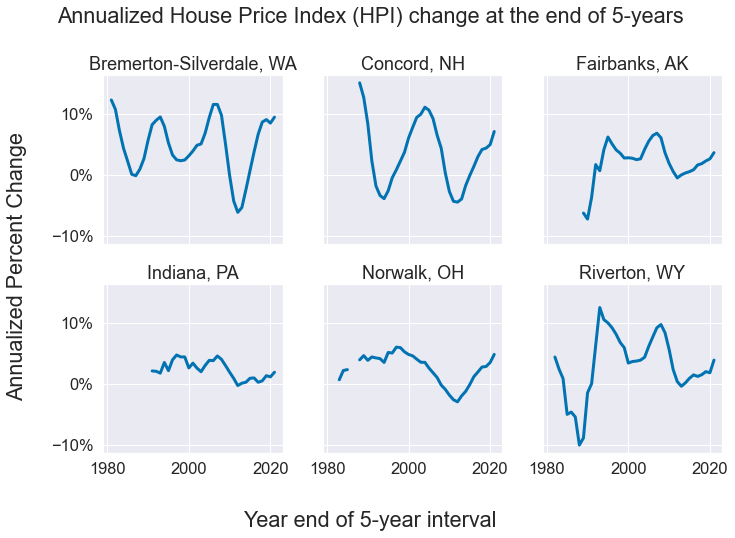

In [30]:
# figure and axes
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (10.5, 7.5), sharex = True, sharey = True)

# flatten axes
axes = axes.flatten()

# index
i = 0

for cbsa_name_i, data_i in hpi_change_x_year.groupby(["cbsa_name"]):
    # scatterplot
    axes[i].plot(data_i["year_end"], data_i["annual_change_frac"], linewidth = 3)

    # axes format
    axes[i].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1, decimals = 0))

    # titles
    axes[i].set(title = f"{cbsa_name_i}")

    # increase index
    i += 1

fig.supxlabel(f"Year end of {interval_length}-year interval")
fig.supylabel("Annualized Percent Change")
fig.suptitle(f"Annualized House Price Index (HPI) change at the end of {interval_length}-years")

# tighten layout
fig.tight_layout()
;

## descriptives

In [31]:
hpi_change_x_year["annual_change_frac"].describe()

count    217.000000
mean       0.031762
std        0.041567
min       -0.099977
25%        0.008916
50%        0.030494
75%        0.051704
max        0.151419
Name: annual_change_frac, dtype: float64

## quantiles

In [32]:
hpi_change_x_year["annual_change_frac"].quantile(np.arange(0, 1.1, 0.1))

0.0   -0.099977
0.1   -0.018637
0.2    0.003159
0.3    0.013428
0.4    0.023254
0.5    0.030494
0.6    0.039233
0.7    0.046278
0.8    0.061632
0.9    0.091633
1.0    0.151419
Name: annual_change_frac, dtype: float64